In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
path = 'WISDM_ar_v1.1_raw.txt'
#Import raw data file with accelerometer data
df = pd.read_csv(path,header=None,names=['user-id','activity','timestamp','x-axis','y-axis','z-axis'])
#Every row in z-axis column ends with a semicolon, need to remove this with regex
df['z-axis'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
#Take an initial look at the data
df.head()
#We have user-specific user-id's, the activity we want to predict, a time which will be our x-axis graphically
#Then we have the 3 accelerometer axes, 'x-axis' is just the direction but won't actually be used as any x-axis

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [4]:
def plt_act(activity, df, rows=len(df),y_label='Acceleration (m/s$^2$)',x_label='Time (min)'):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:rows]*9.8/10
    data = data.reset_index()
    #the data is currently by row, each sample was taken at 50ms, divided by 60000 to get min
    data['index']=(data['index']-min(data['index']))*50/60000
    data = data.set_index('index')
    axis = data.plot(subplots=True, figsize=(16, 12),title=activity)
    plt.xlabel(x_label)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        ax.set_ylabel(y_label)

In [5]:
count_nan = len(df) - df.count()
#Are there any na's?
print(count_nan)
#Remove those
df.dropna(axis=0, how='any', inplace=True)
count_nan = len(df) - df.count()
#Verify all are gone
print(count_nan)

user-id      0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       1
dtype: int64
user-id      0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       0
dtype: int64


In [6]:
df[['user-id','activity','x-axis','y-axis','z-axis']].groupby(['user-id','activity']).count().head(20)

x-axis  y-axis  z-axis
user-id activity                          
1       Downstairs    2941    2941    2941
        Jogging      11056   11056   11056
        Upstairs      3120    3120    3120
        Walking      12861   12861   12861
2       Jogging      11786   11786   11786
        Walking      11739   11739   11739
3       Downstairs    3326    3326    3326
        Jogging      11018   11018   11018
        Sitting       1609    1609    1609
        Standing      2824    2824    2824
        Upstairs      3411    3411    3411
        Walking      12973   12973   12973
4       Downstairs    1763    1763    1763
        Jogging        895     895     895
        Sitting       1257    1257    1257
        Upstairs      1377    1377    1377
        Walking       6079    6079    6079
5       Downstairs    3281    3281    3281
        Jogging       6405    6405    6405
        Sitting       1664    1664    1664

In [7]:
count_d = {}
for activity in df['activity'].unique():
    count = df[df['activity']==activity].shape[0]
    count_d.update({activity:count})
print(count_d)

{'Jogging': 342176, 'Walking': 424397, 'Upstairs': 122869, 'Downstairs': 100427, 'Sitting': 59939, 'Standing': 48395}


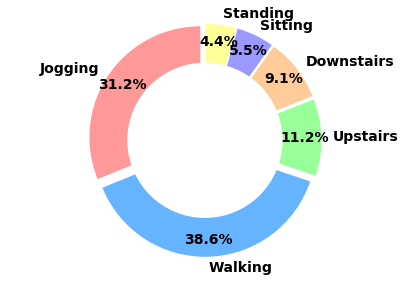

In [8]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

labels = count_d.keys()
sizes = count_d.values()
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#9999ff','#ffff99']
#explsion
explode = (0.05,0.05,0.05,0.05,0.05,0.05)
 
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85,explode=explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

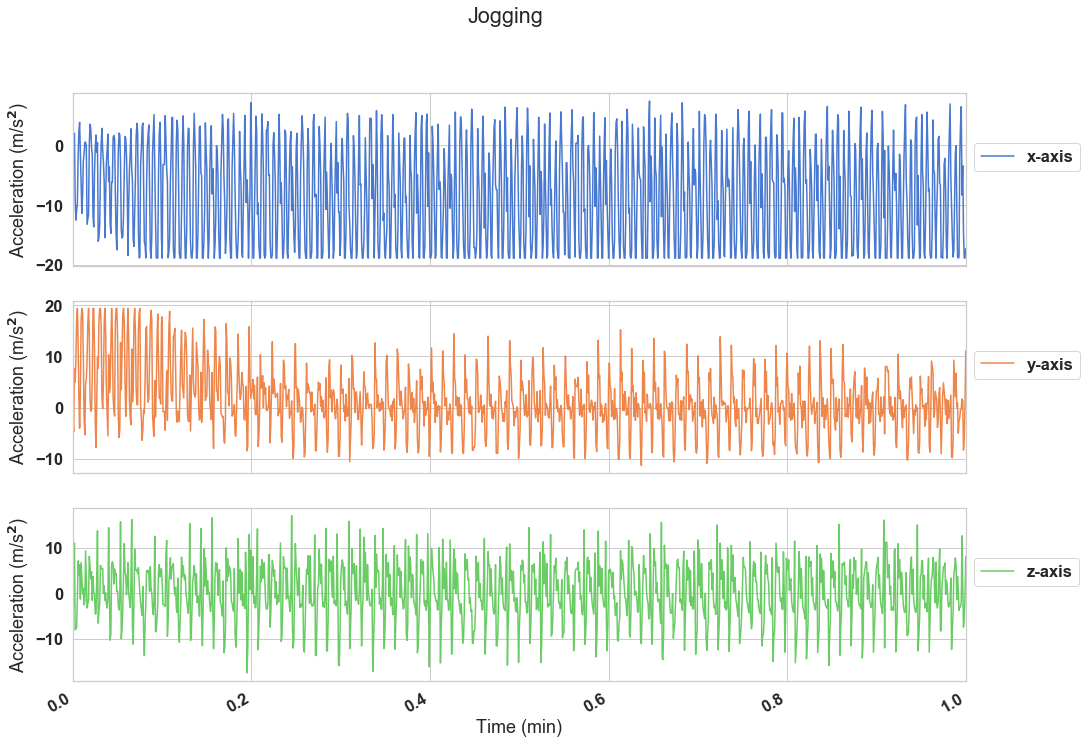

In [9]:
from pylab import rcParams
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
def conflt(data):
    return np.float(data)
#Need to set z-axis back to float after regexing out ';' made it an object
df['z-axis'] = df['z-axis'].apply(conflt)
plt_act("Jogging",df[df['user-id']==3],1201)

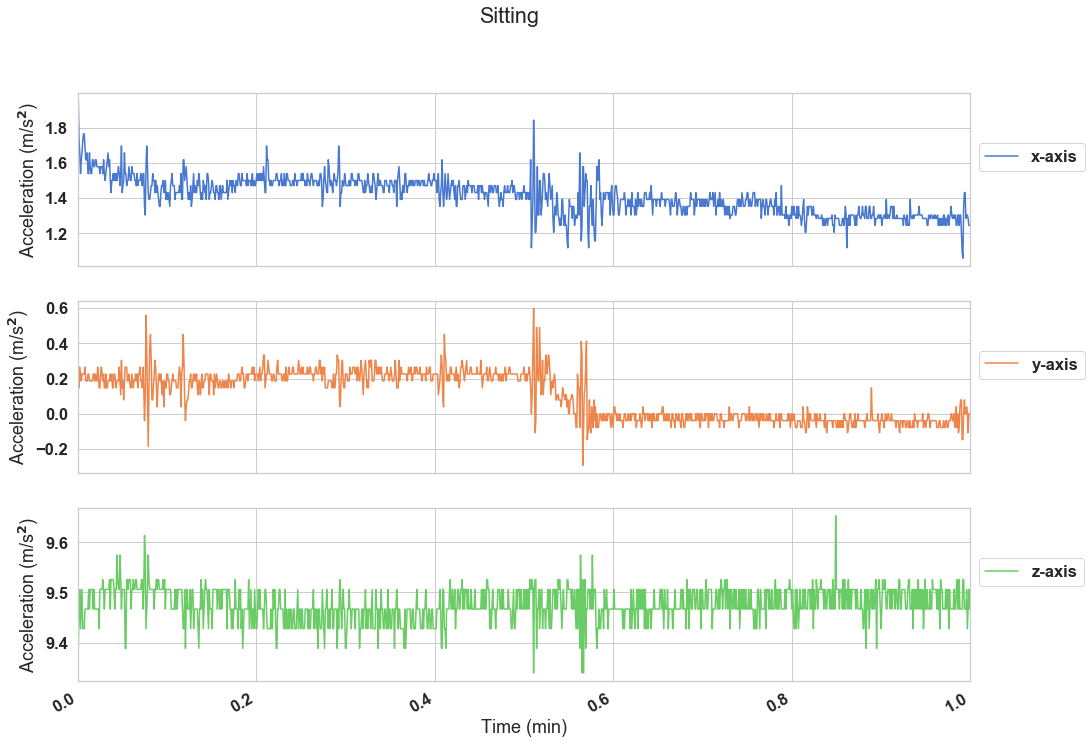

In [10]:
plt_act("Sitting",df[df['user-id']==3],1201)

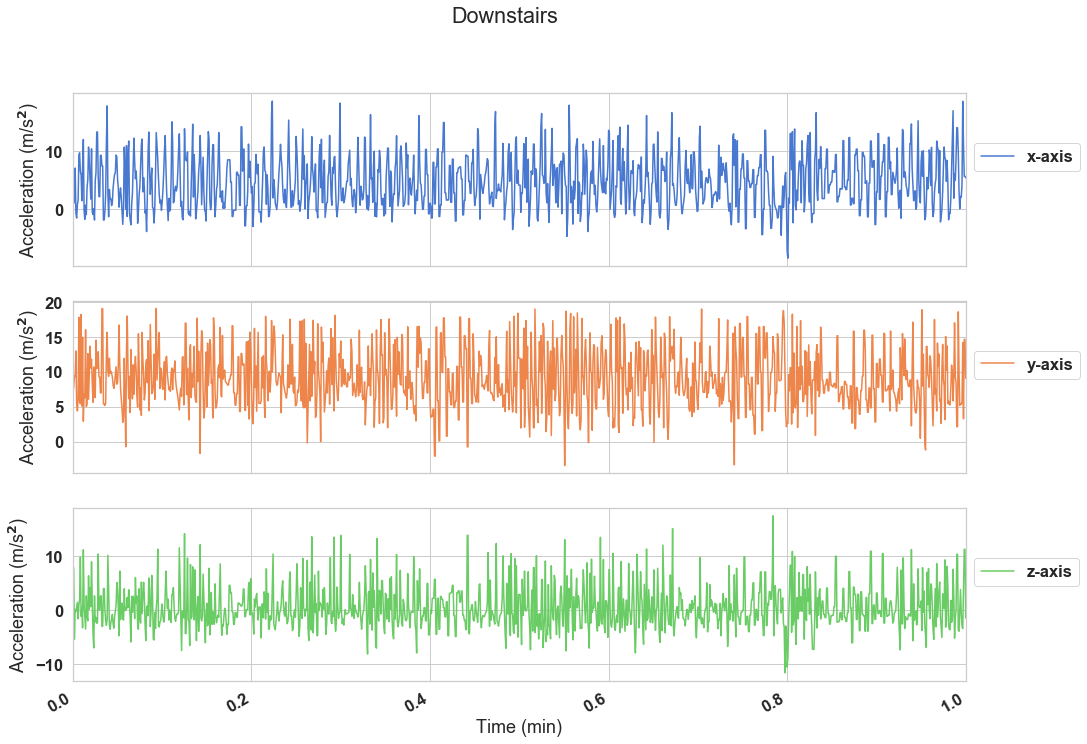

In [11]:
plt_act("Downstairs", df[df['user-id']==16],1201)

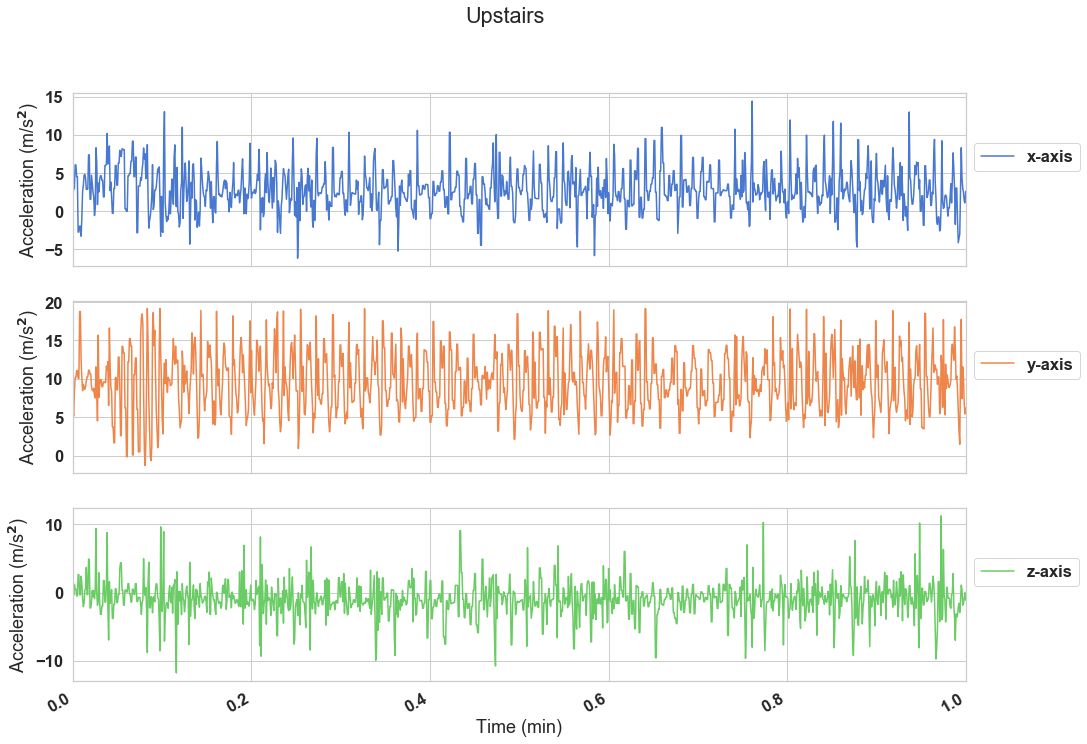

In [12]:
plt_act("Upstairs",df[df['user-id']==16],1201)

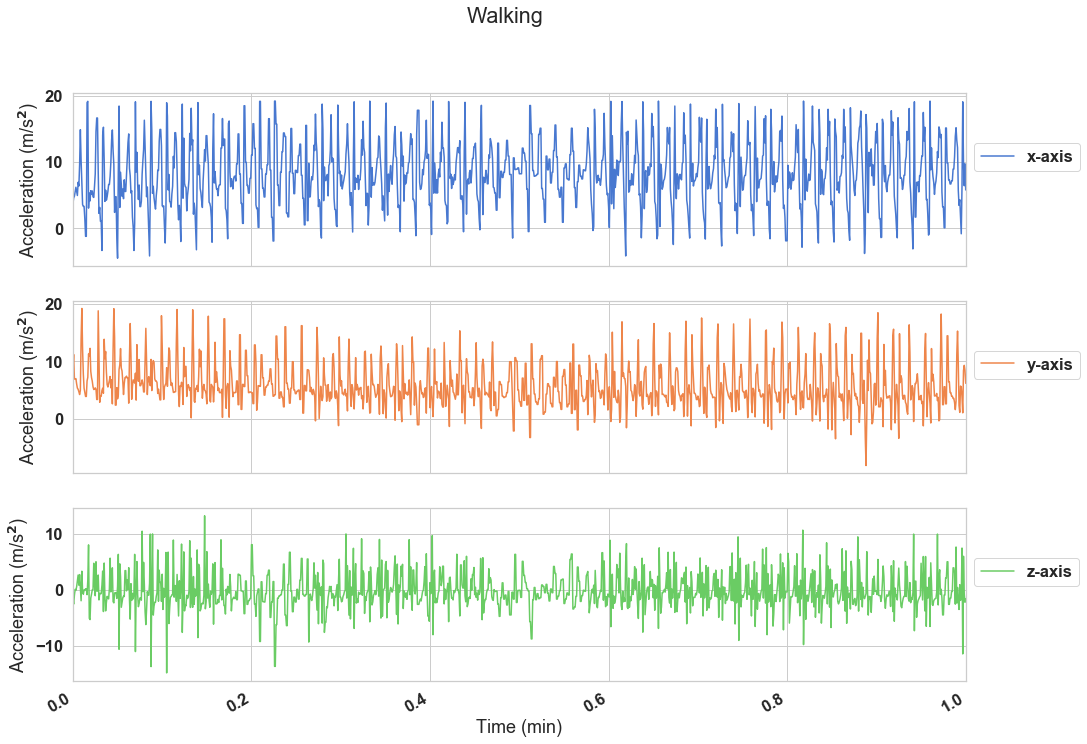

In [13]:
plt_act("Walking", df[df['user-id']==16],1201)

In [14]:
def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [15]:
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

In [16]:
df[df.activity=='Sitting'].tail(5)

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
1098199,19,Sitting,131623331483000,9.00,-1.57,1.69,2
1098200,19,Sitting,131623371431000,9.04,-1.46,1.73,2
1098201,19,Sitting,131623411592000,9.08,-1.38,1.69,2
1098202,19,Sitting,131623491487000,9.00,-1.46,1.73,2
1098203,19,Sitting,131623531465000,8.88,-1.33,1.61,2


In [17]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))
mapping

{'Downstairs': 0,
 'Jogging': 1,
 'Sitting': 2,
 'Standing': 3,
 'Upstairs': 4,
 'Walking': 5}

In [18]:
def get_cutoff(df,percent_train):
    ids = sorted(df['user-id'].unique())
    newList = ids[int(len(ids) * (1-percent_train/100)):]
    return min(newList)
TIME_PERIODS = 80
STEP_DISTANCE = 40
PERCENT_TRAIN = 25
min_user = get_cutoff(df,PERCENT_TRAIN)
df_test = df[df['user-id'] > min_user]
df_train = df[df['user-id'] <= min_user]
x_train, y_train = create_segments_and_labels(df_train,TIME_PERIODS,STEP_DISTANCE,LABEL)

In [19]:
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
y_train = np_utils.to_categorical(y_train, num_classes)
print('New x_train shape: ', x_train.shape)
print('New y_train shape: ', y_train.shape)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
New x_train shape:  (20868, 240)
New y_train shape:  (20868, 6)


In [20]:
x_train.shape

(20868, 240)

In [84]:
from keras.layers import LSTM
#import os
#os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(LSTM(160, return_sequences=True))
model_m.add(LSTM(160, return_sequences=True))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 31, 100)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 22, 160)           160160    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 13, 160)           256160    
_________________________________________________________________
lstm_1 (LSTM)                (None, 13, 160)          

Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 97s 6ms/step - loss: 0.8971 - accuracy: 0.6840 - val_loss: 0.5952 - val_accuracy: 0.7995
Epoch 2/50
16694/16694 [==============================] - 96s 6ms/step - loss: 0.5233 - accuracy: 0.8068 - val_loss: 0.5015 - val_accuracy: 0.8476
Epoch 3/50
16694/16694 [==============================] - 75s 4ms/step - loss: 0.4253 - accuracy: 0.8435 - val_loss: 0.7385 - val_accuracy: 0.7142
Epoch 4/50
16694/16694 [==============================] - 76s 5ms/step - loss: 0.3319 - accuracy: 0.8771 - val_loss: 0.6625 - val_accuracy: 0.7552
Epoch 5/50
16694/16694 [==============================] - 75s 4ms/step - loss: 0.2493 - accuracy: 0.9045 - val_loss: 0.6660 - val_accuracy: 0.7734
Epoch 6/50
16694/16694 [==============================] - 77s 5ms/step - loss: 0.2110 - accuracy: 0.9213 - val_loss: 0.7769 - val_accuracy: 0.7549
Epoch 7/50
16694/16694 [==============================] - 78s 5ms/ste

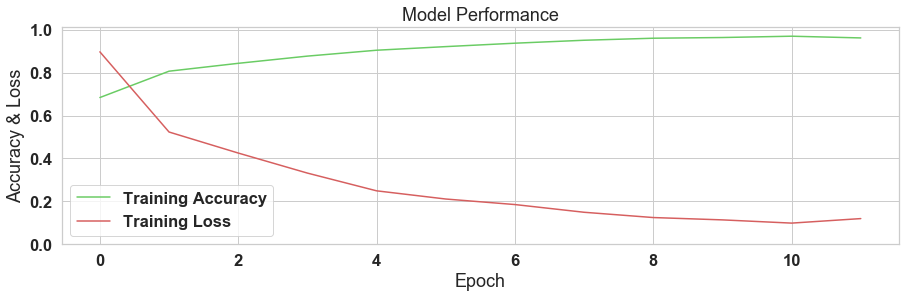

In [85]:
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',monitor='val_loss', save_best_only=True),keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)]

model_m.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=callbacks_list,validation_split=0.2,verbose=1)

plt.figure(figsize=(15, 4))
plt.plot(history.history['accuracy'], "g-", label="Training Accuracy")
#plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r-", label="Training Loss")
#plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [87]:
import pickle
try:
    save_dict
except NameError:
    with open('trainHistoryDict.txt', 'rb') as file_pi:
        save_dict = pickle.load(file_pi)
    print('re-opened')
else:
    print('continuing')
    
model = "Final2Conv1D+2LSTMRev2"
save_dict.update({model:history.history})
#save_dict = {model:history.history}
with open('trainHistoryDict.txt', 'wb') as file_pi:
    pickle.dump(save_dict, file_pi)
with open('trainHistoryDict.txt', 'rb') as file_pi:
    contents = pickle.load(file_pi)
#print(contents)

re-opened


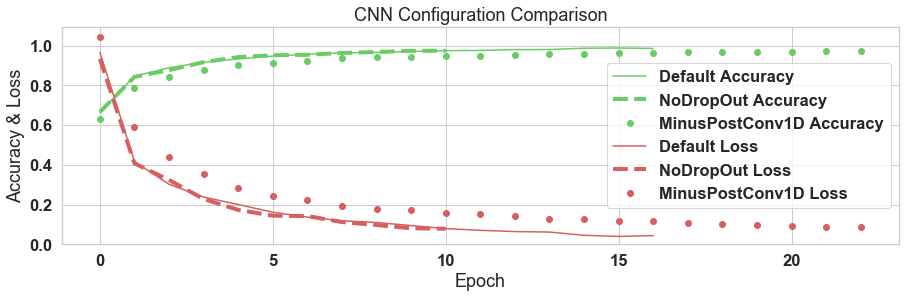

In [88]:
plt.figure(figsize=(15, 4))
plt.plot(contents['Default']['accuracy'], "g-", label="Default Accuracy")
plt.plot(contents['NoDropOut']['accuracy'], "g--", label="NoDropOut Accuracy",linewidth=4)
plt.plot(contents['MinusPostConv1D']['accuracy'], "go", label="MinusPostConv1D Accuracy")
#plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(contents['Default']['loss'], "r-", label="Default Loss")
plt.plot(contents['NoDropOut']['loss'], "r--", label="NoDropOut Loss",linewidth=4)
plt.plot(contents['MinusPostConv1D']['loss'], "ro", label="MinusPostConv1D Loss")
#plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('CNN Configuration Comparison')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylim(0)
plt.legend()
plt.show()

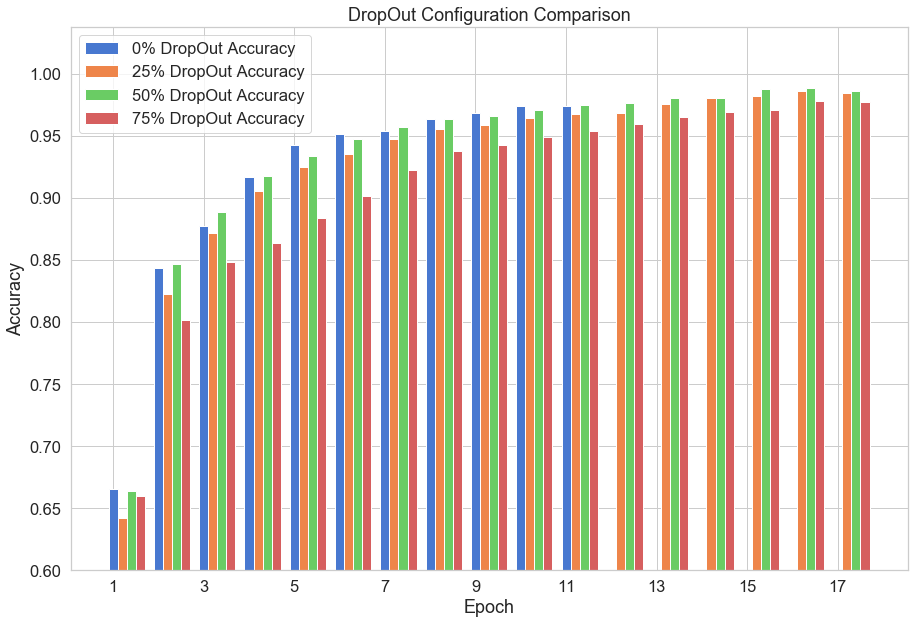

In [459]:
plt.figure(figsize=(15, 10))
width = 0.2
plt.bar(np.arange(1+0*width,1+0*width+len(contents['NoDropOut']['accuracy']), 1).tolist(),contents['NoDropOut']['accuracy'],width,label="0% DropOut Accuracy")
plt.bar(np.arange(1+1*width,1+1*width+len(contents['25DropOut']['accuracy']), 1).tolist(),contents['25DropOut']['accuracy'],width,label="25% DropOut Accuracy")
plt.bar(np.arange(1+2*width,1+2*width+len(contents['Default']['accuracy']), 1).tolist(),contents['Default']['accuracy'],width,label="50% DropOut Accuracy")
plt.bar(np.arange(1+3*width,1+3*width+len(contents['75DropOut']['accuracy']), 1).tolist(),contents['75DropOut']['accuracy'],width,label="75% DropOut Accuracy")
plt.title('DropOut Configuration Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.6)
plt.xticks([1,3,5,7,9,11,13,15,17])
plt.legend()
plt.show()

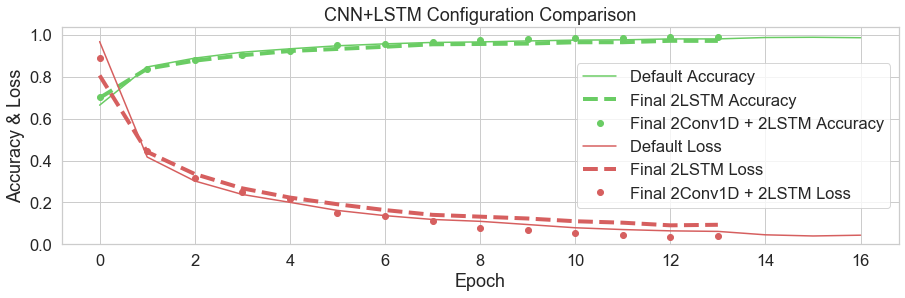

In [494]:
plt.figure(figsize=(15, 4))
plt.plot(contents['Default']['accuracy'], "g-", label="Default Accuracy")
plt.plot(contents['Final2LSTM']['accuracy'], "g--", label="Final 2LSTM Accuracy",linewidth=4)
plt.plot(contents['Final2Conv1D+2LSTM']['accuracy'], "go", label="Final 2Conv1D + 2LSTM Accuracy")
#plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(contents['Default']['loss'], "r-", label="Default Loss")
plt.plot(contents['Final2LSTM']['loss'], "r--", label="Final 2LSTM Loss",linewidth=4)
plt.plot(contents['Final2Conv1D+2LSTM']['loss'], "ro", label="Final 2Conv1D + 2LSTM Loss")
#plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('CNN+LSTM Configuration Comparison')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylim(0)
plt.legend()
plt.show()

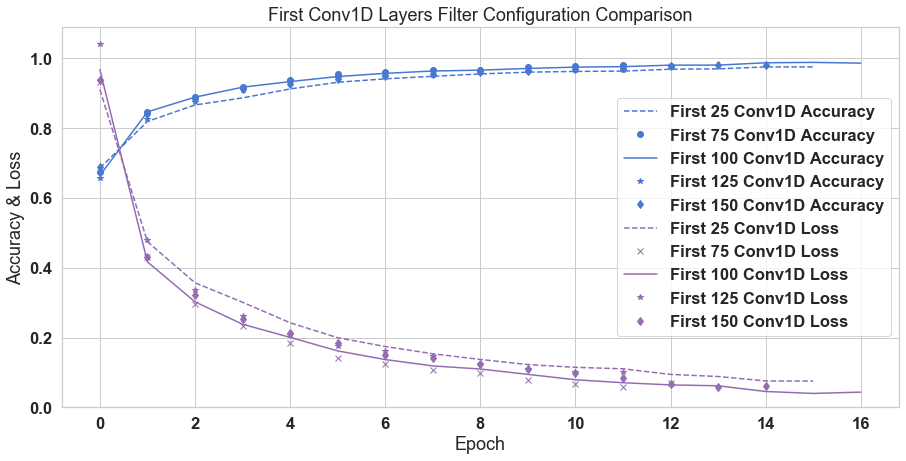

In [331]:
plt.figure(figsize=(15, 7))
plt.plot(contents['First25Conv1D']['accuracy'], "b--", label="First 25 Conv1D Accuracy")
plt.plot(contents['First75Conv1D']['accuracy'], "bo", label="First 75 Conv1D Accuracy")
plt.plot(contents['Default']['accuracy'], "b-", label="First 100 Conv1D Accuracy")
plt.plot(contents['First125Conv1D']['accuracy'], "b*", label="First 125 Conv1D Accuracy")
plt.plot(contents['First150Conv1D']['accuracy'], "bd", label="First 150 Conv1D Accuracy")
#plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(contents['First25Conv1D']['loss'], "m--", label="First 25 Conv1D Loss")
plt.plot(contents['First75Conv1D']['loss'], "mx", label="First 75 Conv1D Loss")
plt.plot(contents['Default']['loss'], "m-", label="First 100 Conv1D Loss")
plt.plot(contents['First125Conv1D']['loss'], "m*", label="First 125 Conv1D Loss")
plt.plot(contents['First150Conv1D']['loss'], "md", label="First 150 Conv1D Loss")
#plt.plot(contents['Final2Conv1D+2LSTM']['loss'], "ro", label="Final 2Conv1D + 2LSTM Loss")
#plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('First Conv1D Layers Filter Configuration Comparison')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylim(0)
plt.legend()
plt.show()

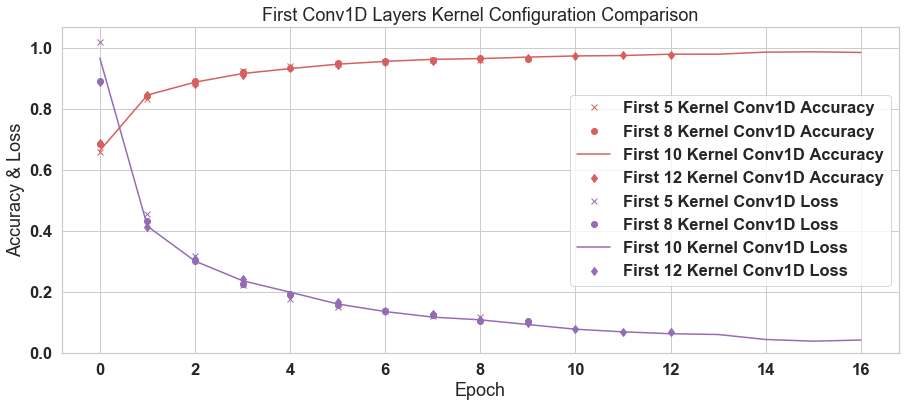

In [364]:
plt.figure(figsize=(15, 6))
plt.plot(contents['First5KernelConv1D']['accuracy'], "rx", label="First 5 Kernel Conv1D Accuracy",linewidth=2)
plt.plot(contents['First8KernelConv1D']['accuracy'], "ro", label="First 8 Kernel Conv1D Accuracy",linewidth=3)
#plt.plot(contents['First75Conv1D']['accuracy'], "bo", label="First 75 Conv1D Accuracy")
plt.plot(contents['Default']['accuracy'], "r-", label="First 10 Kernel Conv1D Accuracy")
plt.plot(contents['First12KernelConv1D']['accuracy'], "rd", label="First 12 Kernel Conv1D Accuracy",linewidth=4)
#plt.plot(contents['First125Conv1D']['accuracy'], "b*", label="First 125 Conv1D Accuracy")
#plt.plot(contents['First150Conv1D']['accuracy'], "bd", label="First 150 Conv1D Accuracy")
#plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(contents['First5KernelConv1D']['loss'], "mx", label="First 5 Kernel Conv1D Loss",linewidth=2)
plt.plot(contents['First8KernelConv1D']['loss'], "mo", label="First 8 Kernel Conv1D Loss",linewidth=3)
#plt.plot(contents['First75Conv1D']['loss'], "mx", label="First 75 Conv1D Loss")
plt.plot(contents['Default']['loss'], "m-", label="First 10 Kernel Conv1D Loss")
plt.plot(contents['First12KernelConv1D']['loss'], "md", label="First 12 Kernel Conv1D Loss",linewidth=4)
#plt.plot(contents['First125Conv1D']['loss'], "m*", label="First 125 Conv1D Loss")
#plt.plot(contents['First150Conv1D']['loss'], "md", label="First 150 Conv1D Loss")
#plt.plot(contents['Final2Conv1D+2LSTM']['loss'], "ro", label="Final 2Conv1D + 2LSTM Loss")
#plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('First Conv1D Layers Kernel Configuration Comparison')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [490]:
max(contents['Final2LSTM']['accuracy'])

0.97142684

In [491]:
max(contents['Final2Conv1D+2LSTM']['accuracy'])

0.9902959

In [89]:
max(contents['Final2Conv1D+2LSTMRev2']['accuracy'])

0.96986943

In [34]:
mapping

{'Downstairs': 0,
 'Jogging': 1,
 'Sitting': 2,
 'Standing': 3,
 'Upstairs': 4,
 'Walking': 5}

Text(0.11, 0.5, 'Filters')

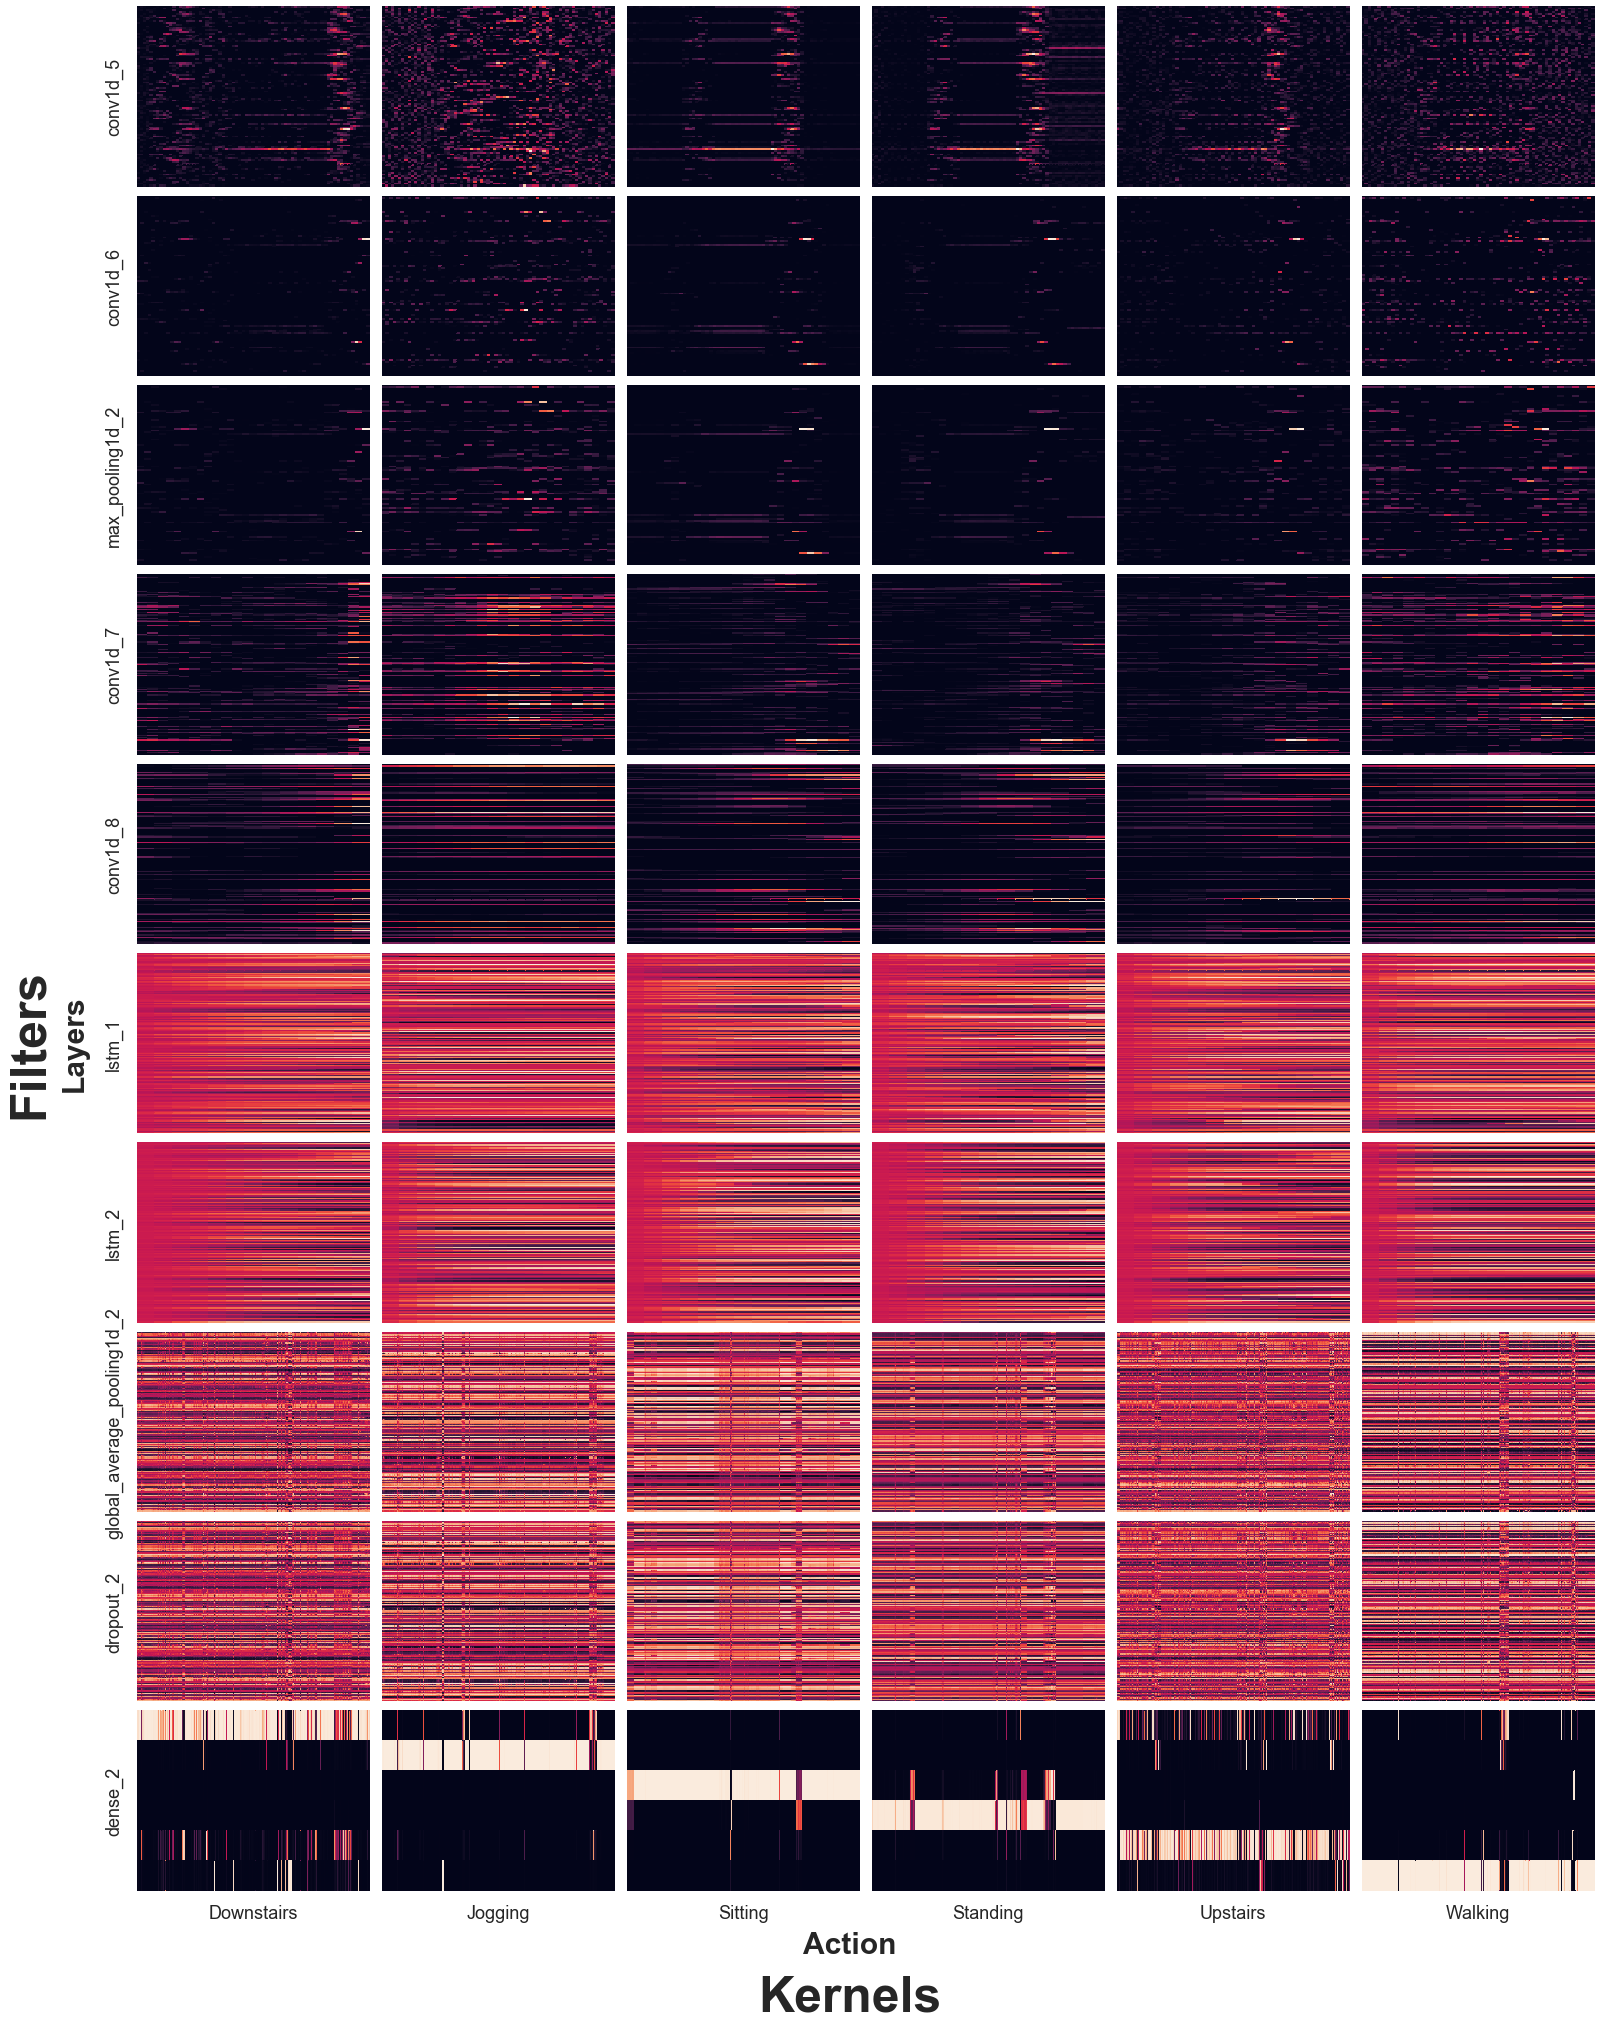

In [226]:
from keras import backend as K
import matplotlib.gridspec as gridspec
lay_len = len(model_m.layers)
#lay_len = 2
activities = list(mapping.keys())
act_len = len(activities)

fig = plt.figure(figsize=(30,32)) 

gs = gridspec.GridSpec(lay_len, act_len, width_ratios=[1,1,1,1,1,1],
                       wspace=0.05, hspace=0.05, top=0.95, bottom=0.05, left=0.17, right=0.845) 

for layer in range(1,lay_len):
        for i in range(0,len(activities)):
            seg_x = create_segments_and_labels(df[df['ActivityEncoded']==i],TIME_PERIODS,STEP_DISTANCE,LABEL)[0]
            get_layer_output = K.function([model_m.layers[0].input],[model_m.layers[layer].output])
            layer_output = get_layer_output([seg_x])[0]
            ax = fig.add_subplot(gs[layer-1,i])
            try: 
                sns.heatmap(layer_output[0].transpose(),cbar=False)
            except:
                sns.heatmap(layer_output.transpose(),cbar=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            if layer == (lay_len-1):
                ax.set_xlabel(activities[i])
            if i == 0:
                ax.set_ylabel(model_m.layers[layer].name)
fig.text(0.5, 0.105, 'Action', ha='center',fontsize=30)
fig.text(0.135, 0.5, 'Layers', va='center', rotation='vertical',fontsize=30)
fig.text(0.5, 0.08, 'Kernels', ha='center',fontsize=50)
fig.text(0.11, 0.5, 'Filters', va='center', rotation='vertical',fontsize=50)

Text(0.5, 1, 'max_pooling1d_2 Downstairs Kernels vs Layers')

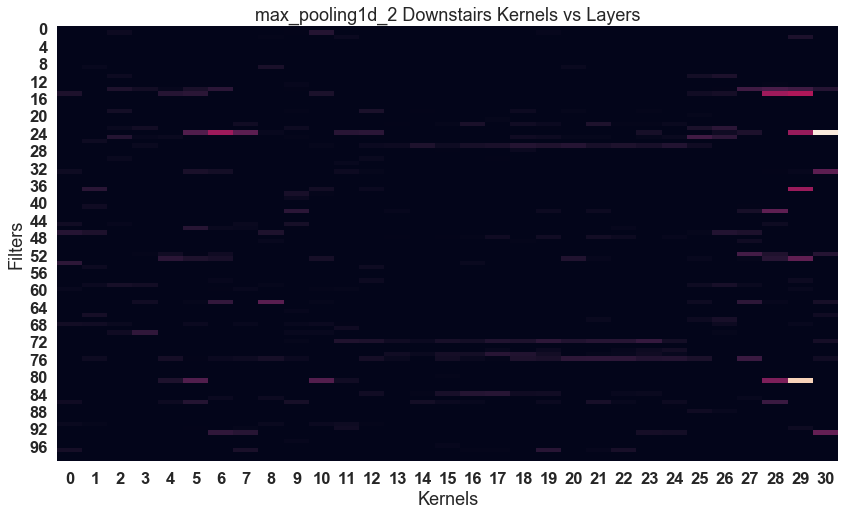

In [227]:
activity = 'Downstairs'
layer = 3

seg_x = create_segments_and_labels(df[df['ActivityEncoded']==mapping[activity]],TIME_PERIODS,STEP_DISTANCE,LABEL)[0]
get_layer_output = K.function([model_m.layers[0].input],[model_m.layers[layer].output])
layer_output = get_layer_output([seg_x])[0]

try: 
    ax = sns.heatmap(layer_output[0].transpose(),cbar=False)
except:
    ax = sns.heatmap(layer_output.transpose(),cbar=False)

#ax.set(xlabel='common xlabel', ylabel='common ylabel')
ax.set_xlabel('Kernels')
ax.set_ylabel('Filters')
ax.set_title(model_m.layers[layer].name + ' ' + activity + ' Kernels vs Layers')
#fig.text(0.5, 0.105, 'Action', ha='center',fontsize=30)
#fig.text(0.135, 0.5, 'Layers', va='center', rotation='vertical',fontsize=30)
#fig.text(0.5, 0.08, 'Filters', ha='center',fontsize=50)
#fig.text(0.11, 0.5, 'Kernels', va='center', rotation='vertical',fontsize=50)

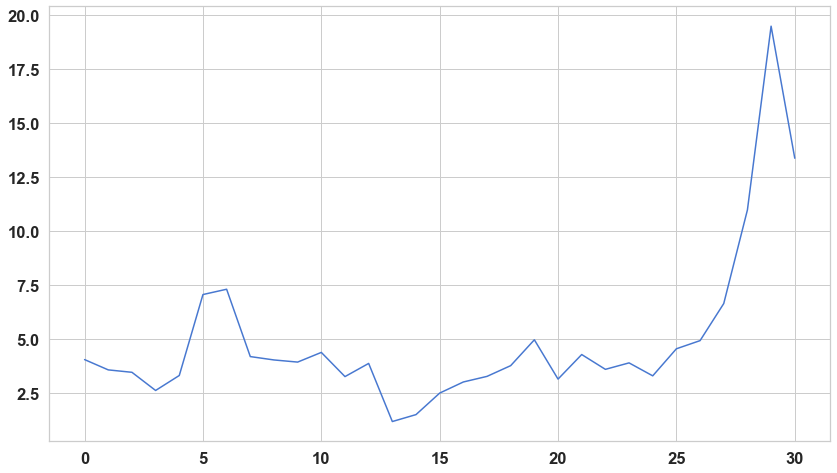

In [223]:
avgs = []
all = []
for i in range(0,layer_output[0].shape[0]):
    avgs.insert(i,np.sum(layer_output[0][i]))
plt.plot(avgs)

In [ ]:
avgs = []
all = []
for i in range(0,layer_output[0].shape[0]):
    avgs.insert(i,np.sum(layer_output[0][i]))
plt.plot(avgs)

In [224]:
layer_output.transpose()

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 1.1966264 ,
         0.        , 1.3158003 ],
        [0.        , 0.        , 0.33380812, ..., 0.        ,
         0.7556753 , 0.        ],
        [0.22426823, 0.32604787, 0.12885375, ..., 0.8167417 ,
         0.99953145, 0.64376867],
        ...,
        [0.        , 0.40371847, 0.09476767, ..., 1.1712474 ,
         0.85202986, 0.        ],
        [0. 